# 1.Loading the data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')


In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

# 2 Time based Spliting CleanedText and Score

In [6]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)
x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]

x_tr,x_test,y_tr,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 3.Bag of Words (BoW)

## 3.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

from sklearn.preprocessing import StandardScaler
x_tr_uni = StandardScaler(with_mean = False).fit_transform(x_tr_uni)
x_test_uni = StandardScaler(with_mean = False).fit_transform(x_test_uni)

## 3.1.1 GridSearchcv


### 3.1.1 Finding the optimal C using gridsearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  8.8min finished


Best HyperParameter:  {'C': 0.01}
0.8901017596066948


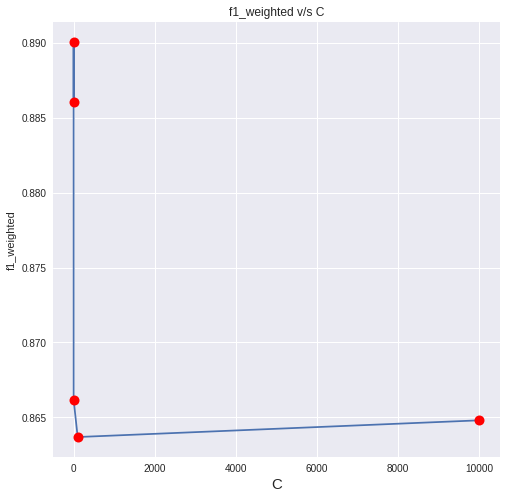

In [13]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 3.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 87.965%
Precision on test set: 0.794
Recall on test set: 0.799
F1-Score on test set: 0.796


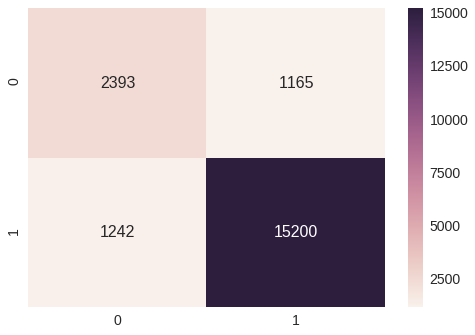

In [14]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_uni,y_tr)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.1.1 RandomSearchcv

### 3.1.1.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.6min finished


Best HyperParameter:  {'C': 0.13497594072466312}
0.871454673558184


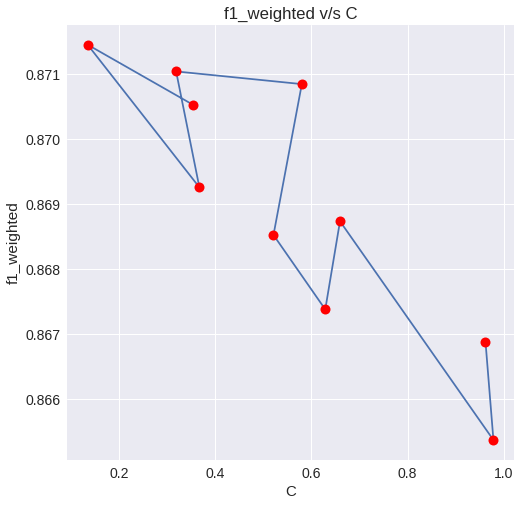

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 3.1.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 89.545%
Precision on test set: 0.825
Recall on test set: 0.811
F1-Score on test set: 0.817


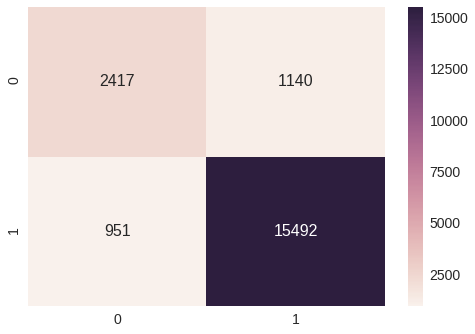

In [17]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_uni,y_tr)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.1.3 Top Feature

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_uni.shape)
x_tr_uni_Epsilon= x_tr_uni + epsilon

### Find with weight vector using train without noise

In [0]:
#value of c is selected as per optimal C in gridsearch
LR= LogisticRegression(penalty='l2',C=0.01)
LR.fit(x_tr_uni,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
#value of c is selected as per optimal C in gridsearch
LR= LogisticRegression(penalty='l1',C=0.01)
LR.fit(x_tr_uni_Epsilon,y_tr)
w_2=LR.coef_

In [0]:
w=(w_2-w_1)
w=w/w_1

In [0]:
w=np.nan_to_num(w)

In [ ]:
w=w*100
#theshold value is 30%
w=w[np.where( w < 30 )]

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos_uni=w[np.where( w > 0 )]
w_Neg_uni=w[np.where( w < 0 )]

In [45]:
features = (-w_Neg_uni).argsort()
print(np.take(bow.get_feature_names(), feature:10]))

['bad' 'rigt' 'loung' 'disappear' 'garam' 'though' 'best' 'warrior' 'aw'
 'urin']


In [44]:
features = (-w_Pos_uni).argsort()
print(np.take(bow.get_feature_names(), features[:10]))

['aaah' 'abdomen' 'aafco' 'aarti' 'abat' 'abbey' 'abc' 'aaf' 'abandon']


## 3.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

x_tr_bi = StandardScaler(with_mean = False).fit_transform(x_tr_bi)
x_test_bi = StandardScaler(with_mean = False).fit_transform(x_test_bi)

## 3.2.1 Gridsearchcv

### 3.2.1.1 Finding the optimal C using gridsearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 12.6min finished


Best HyperParameter:  {'C': 1}
0.8334473416881972


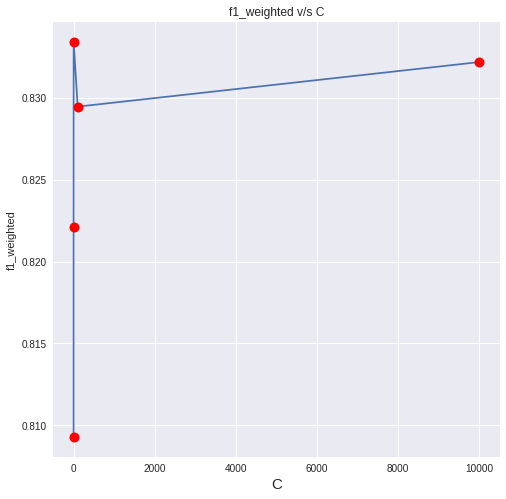

In [11]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_
x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 3.2.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 87.210%
Precision on test set: 0.901
Recall on test set: 0.649
F1-Score on test set: 0.692


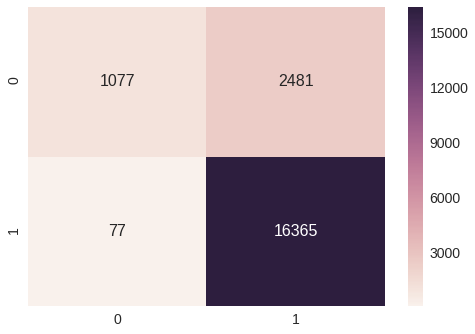

In [31]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_bi,y_tr)
y_pred =LR.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.2.2 RandomSearchCv

### 3.2.2.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.0min finished


Best HyperParameter:  {'C': 0.9957428719436233}
0.8334145839745022


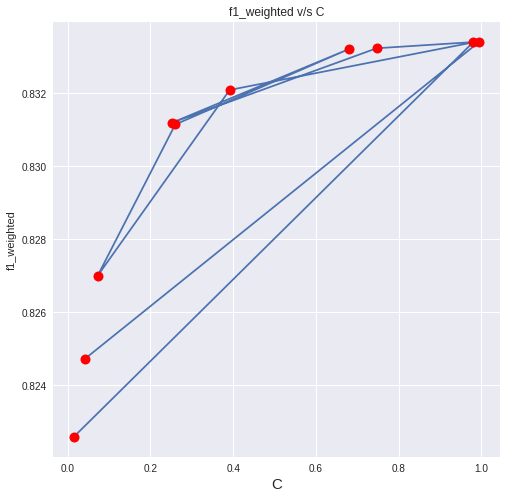

In [11]:
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_
x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 3.2.2.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 87.200%
Precision on test set: 0.901
Recall on test set: 0.649
F1-Score on test set: 0.692


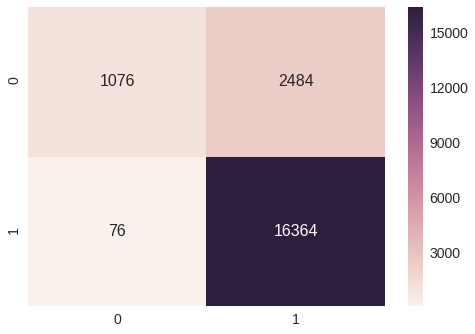

In [24]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_bi,y_tr)
y_pred =LR.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.1.3 Top Feature

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_bi.shape)
x_tr_bi_Epsilon= x_tr_bi + epsilon

### Find with weight vector using train without noise

In [0]:
#value of c is selected as per optimal C in gridsearch
LR= LogisticRegression(penalty='l1',C=1)
LR.fit(x_tr_bi,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1)
LR.fit(x_tr_bi_Epsilon,y_tr)
w_2=LR.coef_

In [0]:
w=(w_2-w_1)
w=w/w_1

In [0]:
w=np.nan_to_num(w)

In [ ]:
w=w*100
#theshold value is 30%
w=w[np.where( w < 30 )]

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos_bi=w[np.where( w > 0 )]
w_Neg_bi=w[np.where( w < 0 )]

In [0]:
features = (-w_Neg_bi).argsort()
print(np.take(bi_gram.get_feature_names(), features[:10]))

['ad splash' 'ahoy' 'alway one' 'alfalfa brown' 'admit latter'
 'amount coconut' 'anyth like' 'acid favorit' 'absorb flavor' 'anoth web']


In [0]:
features = (-w_Pos_bi).argsort()
print(np.take(bi_gram.get_feature_names(), features[:10]))

['ago never' 'age told' 'add peanut' 'aficionado alway' 'almondi anoth'
 'aftertast easi' 'agent made' 'advantag' 'add onto' 'abl purchas']


# 4 TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

x_tr_tfidf = StandardScaler(with_mean = False).fit_transform(x_tr_tfidf)
x_test_tfidf = StandardScaler(with_mean = False).fit_transform(x_test_tfidf)

## 4.1 GridSearchCv

### 4.1.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 12.9min finished


Best HyperParameter:  {'C': 10000}
0.8194864465116225


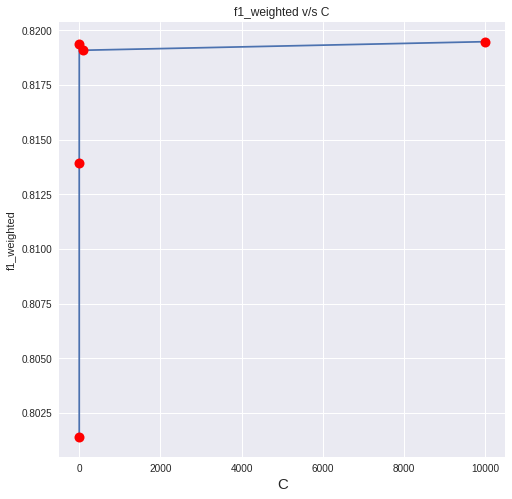

In [13]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_
x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 92.915%
Precision on test set: 0.897
Recall on test set: 0.851
F1-Score on test set: 0.871


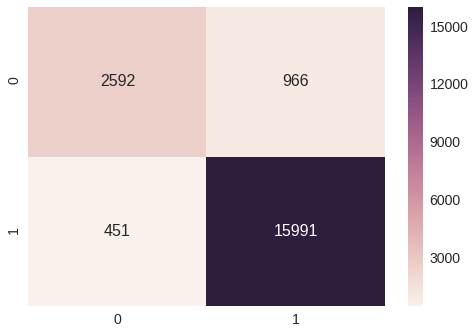

In [23]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tfidf,y_tr)
y_pred =LR.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2 RandomSearchCv

### 4.2.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 25.8min finished


Best HyperParameter:  {'C': 0.8577288513176606}
0.819230363972289


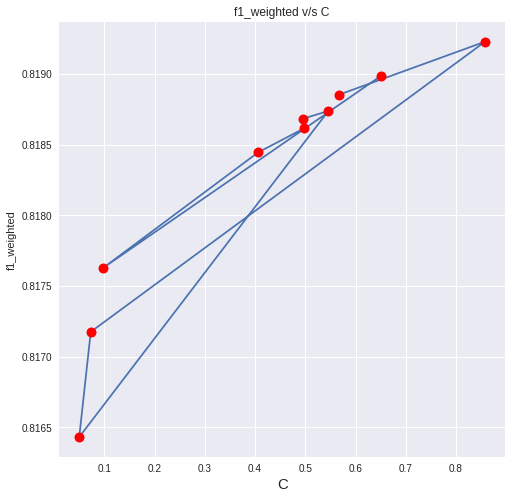

In [14]:
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_
x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()


### 4.2.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 86.295%
Precision on test set: 0.913
Recall on test set: 0.618
F1-Score on test set: 0.652


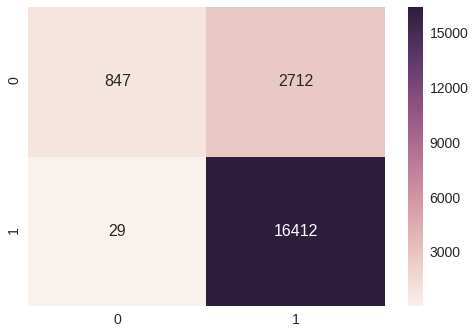

In [44]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tfidf,y_tr)
y_pred =LR.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.3 Top Feature

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_tfidf.shape)
x_tr_tdidf_Epsilon= x_tr_tfidf + epsilon


### Find with weight vector using train without noise

In [0]:
#value of c is selected as per optimal C in gridsearch
LR= LogisticRegression(penalty='l1',C=10000)
LR.fit(x_tr_tfidf,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
#value of c is selected as per optimal C in gridsearch
LR= LogisticRegression(penalty='l1',C=10000)
LR.fit(x_tr_tdidf_Epsilon,y_tr)
w_2=LR.coef_

In [0]:
w=(w_2-w_1)
w=w/w_1

In [0]:
w=np.nan_to_num(w)

In [ ]:
w=w*100
#theshold value is 30%
w=w[np.where( w < 30 )]

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos_tdidf=w[np.where( w > 0 )]
w_Neg_tdidf=w[np.where( w < 0 )]

In [29]:
features = (-w_Neg_tdidf).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features[:10]))

['buyer problem' 'can' 'aftertast slight' 'brew' 'amazon avail'
 'auger smaller' 'deliveri date' 'day ahead' 'bought sever' 'color']


In [30]:
features = (-w_Pos_tdidf).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features[:10]))

['eden' 'brooklyn bean' 'brooklyn cup' 'brooklyn tast' 'broth'
 'crock spoon' 'crock' 'broth egg' 'broth like' 'broth must']


# 5 Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [17]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11262
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'propylen', 'glycol', 'top', 'ingredi', 'ive', 'done']


# 6.Avg W2V

In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

80000
50


In [19]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

20000
50


In [0]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors


x_test_av1 = StandardScaler(with_mean = False).fit_transform(x_test_av1)
x_tr_av1 = StandardScaler(with_mean = False).fit_transform(x_tr_av1)

## 6.1 Gridsearch

### 6.1.1 Finding the optimal C using Gridsearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


Best HyperParameter:  {'C': 1}
0.8794490662633845


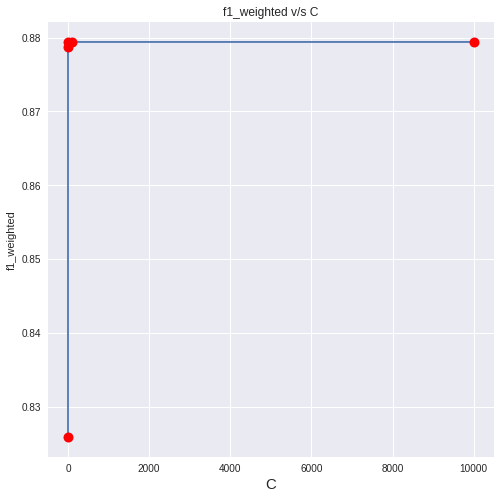

In [21]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 6.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 88.760%
Precision on test set: 0.833
Recall on test set: 0.750
F1-Score on test set: 0.782


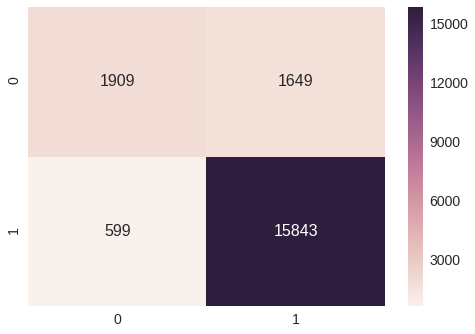

In [31]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_av1,y_tr)
y_pred =LR.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 6.2 RandomSearch

### 6.2.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


Best HyperParameter:  {'C': 0.3695258221706792}
0.8795095275758049


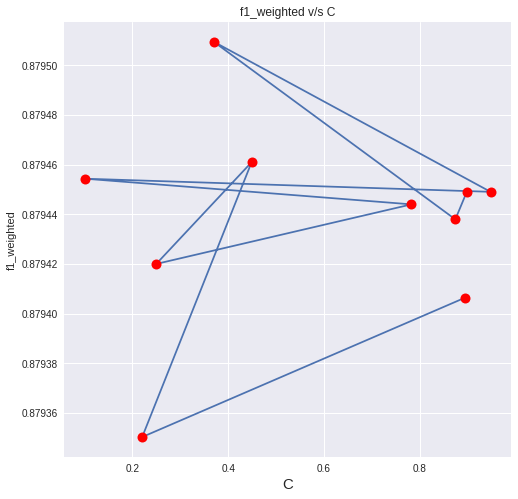

In [22]:
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 6.2.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 88.740%
Precision on test set: 0.833
Recall on test set: 0.750
F1-Score on test set: 0.781


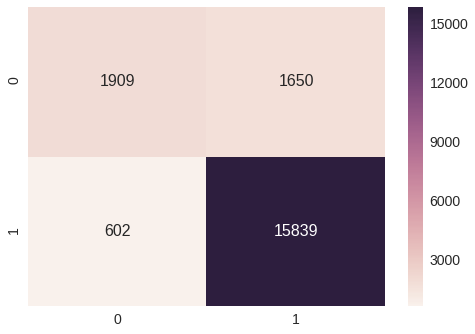

In [51]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_av1,y_tr)
y_pred =LR.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 7.TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [02:27<00:00, 543.16it/s]


In [25]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:39<00:00, 511.96it/s]


In [0]:
x_test_tdfw2v=tfidf_sent_vectors_test
x_tr_tdfw2v=tfidf_sent_vectors


x_test_tdfw2v = StandardScaler(with_mean = False).fit_transform(x_test_tdfw2v)
x_tr_tdfw2v = StandardScaler(with_mean = False).fit_transform(x_tr_tdfw2v)

## 7.1 GridSearchcv

### 7.1.1 Finding the optimal C using GridSearchcv

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.5min finished


Best HyperParameter:  {'C': 100}
0.8590280869140694


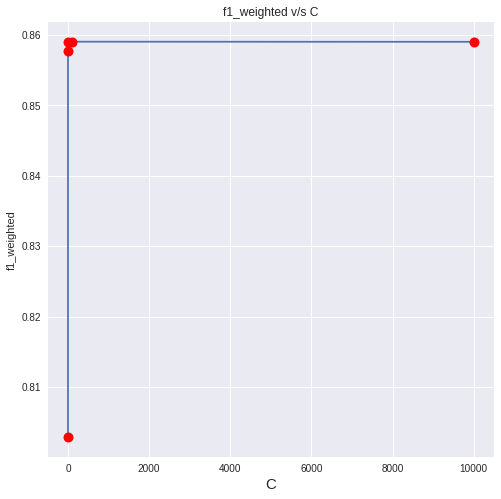

In [27]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 7.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 86.915%
Precision on test set: 0.803
Recall on test set: 0.699
F1-Score on test set: 0.732


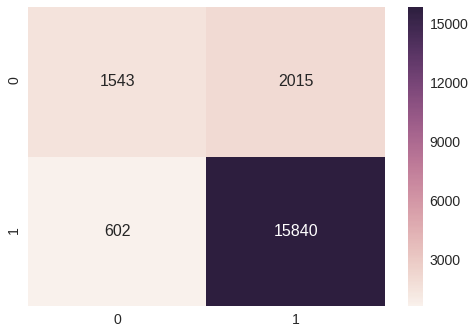

In [36]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tdfw2v,y_tr)
y_pred =LR.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 7.2 RandomSearchcv

### 7.2.1 Finding the optimal C using RandomSearchcv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


Best HyperParameter:  {'C': 0.8393302943106568}
0.8589639671489254


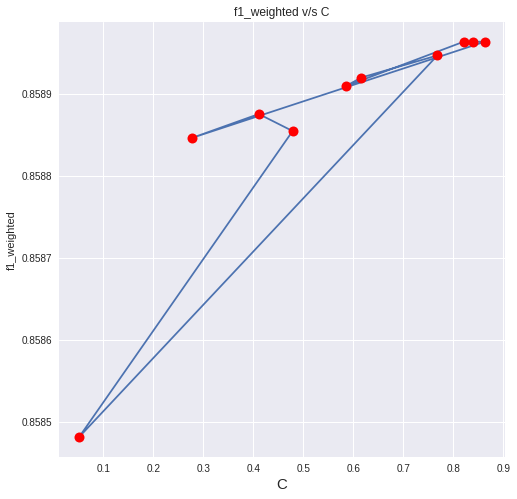

In [28]:
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 7.2.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 86.985%
Precision on test set: 0.805
Recall on test set: 0.700
F1-Score on test set: 0.734


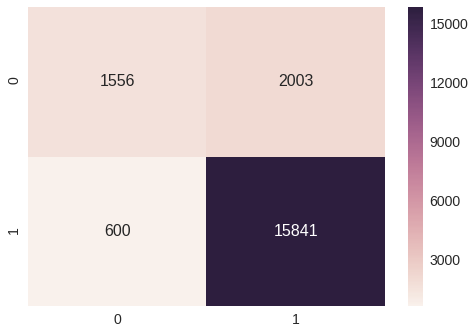

In [56]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tdfw2v,y_tr)
y_pred =LR.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# GridSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  | 0.0001| 0.777|86.7%|
| Bi-gram | 1|0.692|87.210%|
|  Tf-IDF | 10000| 0.87|92.715%|
| Av-Word2Vec |100|0.72|88.7%|
|  Tf-IDF Word2vec | 100|0.732|86.917%|


# RandomSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  | 0.0121|0.817|89.545%|
| Bi-gram | 0.091|0.692|87.200%|
|  Tf-IDF | 0.44| 0.652|86.295%|
| Av-Word2Vec |0.717|0.781|88.74%|
|  Tf-IDF Word2vec | 0.877|0.734|86.9%|
